##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# カスタムフェデレーテッドアルゴリズム、パート 2: フェデレーテッドアベレージングの実装

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/federated/tutorials/custom_federated_algorithms_2"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/federated/blob/v0.20.0/docs/tutorials/custom_federated_algorithms_2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/federated/blob/v0.20.0/docs/tutorials/custom_federated_algorithms_2.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/federated/docs/tutorials/custom_federated_algorithms_2.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

このチュートリアルは、[フェデレーテッドコア（FC）](../federated_core.md)を使用して TFF でフェデレーテッドアルゴリズムのカスタムタイプを実装する方法を示す 2 部較正シリーズのうちの第 2 部です。これは、[フェデレーテッド学習（FL）](../federated_learning.md)レイヤー（`tff.learning`）の基礎として機能します。

まずは[このシリーズの第 1 部](custom_federated_algorithms_1.ipynb)を読むことをお勧めします。第 1 部では、ここで使用される主な概念とプログラミング抽出が説明されています。

シリーズの第 2 部では、第 1 部で導入したメカニズムを使用して、単純なバージョンのフェデレーテッドトレーニングと評価アルゴリズムを実装します。

TFF のフェデレーテッド学習 API に関するより概要レベルのわかりやすい説明については、[画像分類器](federated_learning_for_image_classification.ipynb)と[テキスト生成](federated_learning_for_text_generation.ipynb)のチュートリアルをご覧ください。ここで説明する概念を文脈的に当てはめる上で役に立ちます。

## 始める前に

始める前に、以下の「Hello World」の例を実行して、環境が正しく設定されていることを確認してください。動作しない場合は、[インストール](../install.md)ガイドをご覧ください。

In [2]:
#@test {"skip": true}
!pip install --quiet --upgrade tensorflow_federated_nightly
!pip install --quiet --upgrade nest_asyncio

import nest_asyncio
nest_asyncio.apply()

In [3]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

# TODO(b/148678573,b/148685415): must use the reference context because it
# supports unbounded references and tff.sequence_* intrinsics.
tff.backends.reference.set_reference_context()

In [4]:
@tff.federated_computation
def hello_world():
  return 'Hello, World!'

hello_world()

b'Hello, World!'

## フェデレーテッドアベレージングを実装する

[画像分類器用のフェデレーテッド学習](federated_learning_for_image_classification.ipynb)のように MNIST サンプルを使用しますが、これは低レベルのチュートリアルを目的としているため、Keras API と `tff.simulation` をバイパスし、生のモデルのコードを記述して、ゼロからフェデレーテッドデータセットを構築することにします。


### フェデレーテッドデータセットを準備する

実演の目的により、10 人のユーザーから得たデータを使用し、各ユーザーが異なる数字を識別する方法に関する知識を貢献するというシナリオをシミュレーションすることにします。これは、ほぼ [i.i.d](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) です。

最初に、標準 MNIST データを読み込みましょう。

In [5]:
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

In [6]:
[(x.dtype, x.shape) for x in mnist_train]

[(dtype('uint8'), (60000, 28, 28)), (dtype('uint8'), (60000,))]

データはNumpy 配列として提供されます。1 つは画像を含み、もう 1 つは数字ラベルを含みます。どちらも最初の次元は個々の例に適用されます。フェデレーテッドシーケンスを TFF 計算にフィードする方法と互換性のある方法、つまりリストのリストとしてフォーマットするヘルパー関数を記述しましょう。各クライアントのシーケンスにおけうｒユーザーに及ぶ外部リスト（数値）とデータのバッチに及ぶ内部リストです。このようなバッチを、通例どおり、`x` と `y` という名前のついた、それぞれに主要なバッチ次元のあるテンソルのペアとして構成します。これを行いながら、各画像を 784 要素のベクトルに平板化し、そのピクセルを `0..1` の範囲にスケーリングし直して、データ変換によってモデルのロジックが混乱しないようにします。

In [7]:
NUM_EXAMPLES_PER_USER = 1000
BATCH_SIZE = 100


def get_data_for_digit(source, digit):
  output_sequence = []
  all_samples = [i for i, d in enumerate(source[1]) if d == digit]
  for i in range(0, min(len(all_samples), NUM_EXAMPLES_PER_USER), BATCH_SIZE):
    batch_samples = all_samples[i:i + BATCH_SIZE]
    output_sequence.append({
        'x':
            np.array([source[0][i].flatten() / 255.0 for i in batch_samples],
                     dtype=np.float32),
        'y':
            np.array([source[1][i] for i in batch_samples], dtype=np.int32)
    })
  return output_sequence


federated_train_data = [get_data_for_digit(mnist_train, d) for d in range(10)]

federated_test_data = [get_data_for_digit(mnist_test, d) for d in range(10)]

サニティーチェックをさっと行うために、5 番目のクライアント（数値 `5` に対応するクライアント）が貢献したデータの最後のバッチにある `Y` テンソルを確認しましょう。

In [8]:
federated_train_data[5][-1]['y']

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

確認のため、そのバッチの最後の要素に対応する画像も見てみましょう。

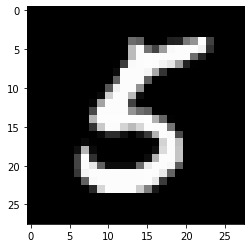

In [9]:
from matplotlib import pyplot as plt

plt.imshow(federated_train_data[5][-1]['x'][-1].reshape(28, 28), cmap='gray')
plt.grid(False)
plt.show()

### TensorFlow と TFF の組み合わせについて

このチュートリアルでは、読みやすくまとめるために、TensorFlow ロジックを導入する関数をすぐに `tff.tf_computation` でデコレートしていますが、より複雑なロジックの場合にお勧めするパターンではありません。TensorFlow のデバッグはすでに困難であり、完全にシリアル化された上で再インポートされた後の TensorFlow のデバッグは、必然的にメタデータを失ってインタラクティビティを制限するため、デバッグがさらに困難となります。

そのため、**複雑な TF ロジックはスタンドアロンの Python 関数として記述することを強くお勧めします**（`tff.tf_computation` デコレーションを使用せずに、ということです）。こうすることで、TFF への計算をシリアル化する前に TF のベストプラクティスとツール（Eager モードなど）を使用して（Python 関数を引数として`tff.tf_computation` を呼び出すことで）、TensorFlow ロジックを開発およびテストすることができます。

### 損失関数を定義する

データの用意ができたため、トレーニングに使用する損失関数を定義しましょう。まず、入力のタイプを TFF の名前付きタプルとして定義思案す。データバッチのサイズは多様であるため、バッチの次元を `None` に設定して、弧の次元のサイズが不明であることを指定します。

In [10]:
BATCH_SPEC = collections.OrderedDict(
    x=tf.TensorSpec(shape=[None, 784], dtype=tf.float32),
    y=tf.TensorSpec(shape=[None], dtype=tf.int32))
BATCH_TYPE = tff.to_type(BATCH_SPEC)

str(BATCH_TYPE)

'<x=float32[?,784],y=int32[?]>'

なぜ通常の Python タイプを定義できないのかと思っているかもしれませんが、[第 1 部](custom_federated_algorithms_1.ipynb)において、Python を使って TFF 計算のロジックを表現できたとしても、内部的には TFF 計算は Python として*扱われない*と説明したことを思い出してください。上記で定義されたシンボル `BATCH_TYPE` は、抽象的な TFF タイプの仕様を表します。この*抽象的な* TFF タイプと具象的な Python *式*タイプ（Python 関数の本文で TFF タイプを表現するために使用される `dict` や `collections.namedtuple` といったコンテナなど）を区別することが重要です。Python とは異なり、TFF には、タプル式コンテナ用に単一の抽象型コンストラクタ `tff.StructType` があり、個別に名前を付けたり無名のままにできる要素が伴います。TFF 計算は仮に 1 つのパラメータと 1 つの結果のみを定義できるため、このタイプは計算の仮パラメータもモデルするために使用できます。この例については以下の方で紹介されています。

では、TFF タイプのモデルパラメータを定義しましょう。もう一度、TFF の*重み*と*バイアス*の名前付きタプルとして定義します。

In [11]:
MODEL_SPEC = collections.OrderedDict(
    weights=tf.TensorSpec(shape=[784, 10], dtype=tf.float32),
    bias=tf.TensorSpec(shape=[10], dtype=tf.float32))
MODEL_TYPE = tff.to_type(MODEL_SPEC)

print(MODEL_TYPE)

<weights=float32[784,10],bias=float32[10]>


上記の定義が完了したところで、シングルバッチにおける特定のモデルの損失を定義することができます。`@tff.tf_computation` 内に `@tf.function` デコレータが使用されるところに注意してください。こうすることで、`tff.tf_computation` デコレータが作成した `tf.Graph` のコンテキスト内であっても、Python 式のセマンティクスを使用して TF を記述することができます。

In [12]:
# NOTE: `forward_pass` is defined separately from `batch_loss` so that it can 
# be later called from within another tf.function. Necessary because a
# @tf.function  decorated method cannot invoke a @tff.tf_computation.

@tf.function
def forward_pass(model, batch):
  predicted_y = tf.nn.softmax(
      tf.matmul(batch['x'], model['weights']) + model['bias'])
  return -tf.reduce_mean(
      tf.reduce_sum(
          tf.one_hot(batch['y'], 10) * tf.math.log(predicted_y), axis=[1]))

@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)
def batch_loss(model, batch):
  return forward_pass(model, batch)

期待した通り、`batch_loss` の計算では、モデルと単一のデータバッチに `float32` 型の損失が返されます。`MODEL_TYPE` と `BATCH_TYPE` が 2 タプルの仮パラメータにひとまとめにされており、`batch_loss` の型を `(<MODEL_TYPE,BATCH_TYPE> -> float32)` として認識することができます。

In [13]:
str(batch_loss.type_signature)

'(<model=<weights=float32[784,10],bias=float32[10]>,batch=<x=float32[?,784],y=int32[?]>> -> float32)'

サニティーチェックとして、ゼロが埋められた初期モデルを構築し、上記で視覚化したデータのバッチでの損失を計算しましょう。

In [14]:
initial_model = collections.OrderedDict(
    weights=np.zeros([784, 10], dtype=np.float32),
    bias=np.zeros([10], dtype=np.float32))

sample_batch = federated_train_data[5][-1]

batch_loss(initial_model, sample_batch)

2.3025851

`dict` として定義された初期モデルで TFF 計算をフィードします。これは、それを定義する Python 関数の本文が、`model['weight']` と `model['bias']` としてモデルパラメータを消費する場合でもです。`batch_loss` への呼び出しの引数は、単純にその関数の本文に渡されません。

`batch_loss` を呼び出す場合に何が起きるでしょうか。`batch_loss` の Python 本文は、それが定義された上記のセルでトレースされ、シリアル化されています。TFF は、計算の定義時に `batch_loss` の呼び出し元として機能し、`batch_loss` の呼び出し時に呼び出しのターゲットとして機能します。両方の役割において、TFF は TFF の象徴タイプシステムと Python 式表現タイプの橋渡しとして動作します。呼び出し時には、TFF はほとんどの標準 Python コンテナタイプ（`dict`、`list`、`tuple`、`collections.namedtuple` など）を抽象的な TFF タプルの具象表現として受け入れます。また、上記で述べたように、TFF 計算は仮に単一のパラメータのみを受け入れるため、パラメータの型がタプルである場合に位置やキーワード引数を使った使い慣れた Python 呼び出しを使用することができ、期待通りに動作します。

### シングルバッチの勾配降下

では、この損失関数を使用して単一ステップの勾配降下を実行する計算を定義しましょう。この関数を定義するにおいて、`batch_loss` をサブコンポーネントとして使用することに注意してください。別の計算の本文内に `tff.tf_computation` で構築された計算を呼び出すことはできますが、通常そうする必要はありません。上記で述べたように、シリアル化によってデバッグ情報の一部が損なわれるため、より複雑な計算で、`tff.tf_computation` デコレータを使用せずにすべての TensorFlow を記述してテストすることが好ましいといえます。

In [15]:
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE, tf.float32)
def batch_train(initial_model, batch, learning_rate):
  # Define a group of model variables and set them to `initial_model`. Must
  # be defined outside the @tf.function.
  model_vars = collections.OrderedDict([
      (name, tf.Variable(name=name, initial_value=value))
      for name, value in initial_model.items()
  ])
  optimizer = tf.keras.optimizers.SGD(learning_rate)

  @tf.function
  def _train_on_batch(model_vars, batch):
    # Perform one step of gradient descent using loss from `batch_loss`.
    with tf.GradientTape() as tape:
      loss = forward_pass(model_vars, batch)
    grads = tape.gradient(loss, model_vars)
    optimizer.apply_gradients(
        zip(tf.nest.flatten(grads), tf.nest.flatten(model_vars)))
    return model_vars

  return _train_on_batch(model_vars, batch)

In [16]:
str(batch_train.type_signature)

'(<initial_model=<weights=float32[784,10],bias=float32[10]>,batch=<x=float32[?,784],y=int32[?]>,learning_rate=float32> -> <weights=float32[784,10],bias=float32[10]>)'

こういった別の関数の本文内で `tff.tf_computation` でデコレートされた Python 関数を呼び出す場合、内部の TFF 計算のロジックは外部の TFF 計算のロジックに埋め込まれます（基本的にインライン）。前述のとおり、両方の計算を記述している場合は、内部関数（この場合 `batch_loss`）を、`tff.tf_computation` ではなく、通常の Python または `tf.function` にするのが好ましいといえますが、ここでは別の関数内で 1 つの `tff.tf_computation` を呼び出しても期待通りに動作します。これは、`batch_loss` を定義している Python コードがないが、シリアル化された TFF 表現しかない場合に、必要となります。

では、この関数を初期モデルに何度か適用して、損失が縮減するかどうかを見てみましょう。

In [17]:
model = initial_model
losses = []
for _ in range(5):
  model = batch_train(model, sample_batch, 0.1)
  losses.append(batch_loss(model, sample_batch))

In [18]:
losses

[0.19690023, 0.13176313, 0.10113225, 0.08273812, 0.070301384]

### 一連のローカルデータの勾配降下

`batch_train` が動作しているようなので、あるユーザーのｎシングルバッチからだけでなく、すべてのバッチの全シーケンスを消費する `local_train` という類似したトレーニング関数を記述しましょう。新しい計算では、`BATCH_TYPE` ではなく `tff.SequenceType(BATCH_TYPE)` を消費する必要があります。

In [19]:
LOCAL_DATA_TYPE = tff.SequenceType(BATCH_TYPE)

@tff.federated_computation(MODEL_TYPE, tf.float32, LOCAL_DATA_TYPE)
def local_train(initial_model, learning_rate, all_batches):

  # Mapping function to apply to each batch.
  @tff.federated_computation(MODEL_TYPE, BATCH_TYPE)
  def batch_fn(model, batch):
    return batch_train(model, batch, learning_rate)

  return tff.sequence_reduce(all_batches, initial_model, batch_fn)

In [20]:
str(local_train.type_signature)

'(<initial_model=<weights=float32[784,10],bias=float32[10]>,learning_rate=float32,all_batches=<x=float32[?,784],y=int32[?]>*> -> <weights=float32[784,10],bias=float32[10]>)'

この短いコードセクションには、たくさんの詳細が含められているため、1 つずつ確認することにします。

まず、先に行ったように、このロジックを TensorFlow だけで実装し、`tf.data.Dataset.reduce` に頼ってシーケンスを処理することも可能ですが、今回は、`tff.federated_computation` として、グルー言語でロジックを表現することを省略しています。還元を実行するために、フェデレーテッド演算子 `tff.sequence_reduce` を使用しました。

演算子 `tff.sequence_reduce` は `tf.data.Dataset.reduce` と同じように使用されています。基本的には `tf.data.Dataset.reduce` と同じように考えることができますが、フェデレーテッド計算内で使用する場合、覚えていらっしゃるかもしれませんが、TensorFlow コードを含めることができません。これは、`T` タイプの要素の*シーケンス*、あるタイプ `U` の還元の初期状態（これを抽象的に*ゼロ*と呼びます）、単一要素を処理することで還元の状態をアラートするタイプ `(<U,T> -> U)` の*還元演算子*で較正される仮の 3 組タプルのパラメータを使用する、テンプレート演算子です。すべての要素を順に処理した後の還元の最終状態が結果となります。この例では、還元の状態は、データの接頭辞でトレーニングされたモデルで、要素はデータのバッチです。

次に、再度、1 つの計算を（`batch_train`）を別の計算（`local_train`）内のコンポーネントとして使用していますが、直接的でないところに注意してください。これは学習率という別のパラメータを追加で使用するため、還元演算子としては使用することができないためです。これを解決するために、本文で `local_train` のパラメータ `learning_rate` にバインドする埋め込みフェデレーテッド計算 `batch_fn` を定義します。子計算が親計算の本文の外で呼び出されない限り、このように定義された子計算が親計算の仮のパラメータをキャプチャすることができます。このパターンは、Python の `functools.partial` に相当すると捉えることができます。

この方法で `learning_rate` を取得した場合には、もちろん実際的に、すべてのバッチで同じ学習率の値が使用されることになります。

では、新たに定義したローカルトレーニング関数を、サンプルバッチ（数値 `5`）を貢献した同一ユーザーのデータの全シーケンスで試してみましょう。

In [21]:
locally_trained_model = local_train(initial_model, 0.1, federated_train_data[5])

うまくいきましたか。この問いに答えるには、評価を実装する必要があります。

### ローカル評価

次は、すべてのデータバッチの損失を加算してローカル評価を実装した一例です（平均を計算することもできましたが、読み手の演習として、取っておくことにします）。

In [22]:
@tff.federated_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
def local_eval(model, all_batches):
  # TODO(b/120157713): Replace with `tff.sequence_average()` once implemented.
  return tff.sequence_sum(
      tff.sequence_map(
          tff.federated_computation(lambda b: batch_loss(model, b), BATCH_TYPE),
          all_batches))

In [23]:
str(local_eval.type_signature)

'(<model=<weights=float32[784,10],bias=float32[10]>,all_batches=<x=float32[?,784],y=int32[?]>*> -> float32)'

また、このコードで説明される新しい要素がいくつかあるので、1 つずつ確認しましょう。

まず、シーケンスの処理に、2 つの新しいフェデレーテッド演算子を使用しています。*マッピング関数* <code>T-&gt;U</code> と `T` の<em>sequence</em>を取って、マッピング関数をポイントごとに適用して取得される `U` のシーケンスを放出する <code>tff.sequence_map</code> と、すべての要素をただ加算する <code>tff.sequence_sum</code> です。ここでは、各データバッチを損失値にマッピングし、結果の損失値を加算して合計損失を計算します。

`tff.sequence_reduce` をもう一度使用することもできましたが、これは最善の選択肢ではありません。還元プロセスは、その定義上シーケンシャルですが、マッピングと加算は並行して計算されるからです。選択肢がある場合は、実装の選択肢に制約を与えない演算子を使用することが最善であり、TFF 計算が将来的に特定の環境にデプロイされるようにコンパイルした場合に、より高速でスケーラブルな、リソース効率に優れた実行を行うためのあらゆる潜在的な機会をまるごと活用することができます。

次に、`local_train` と同じように、必要なコンポーネント関数（`batch_loss`）はフェデレーテッド演算子（`tff.sequence_map`）が期待する数より多いパラメータを取るため、もう一度部分的な定義を行っています。今回は、`lambda` を `tff.federated_computation` として直接タッピングしてインライン化しています。`tff.tf_computation` を使用して TFF に TensorFlow ロジックを埋め込むには、関数を引数として、ラッパーをインラインで使用することが推奨されます。

では、トレーニングが機能するかどうかを確認しましょう。

In [24]:
print('initial_model loss =', local_eval(initial_model,
                                         federated_train_data[5]))
print('locally_trained_model loss =',
      local_eval(locally_trained_model, federated_train_data[5]))

initial_model loss = 23.025854
locally_trained_model loss = 0.4348469


まさに、損失が減少しました。しかし、別のユーザーのデータで評価する場合はどうでしょうか。

In [25]:
print('initial_model loss =', local_eval(initial_model,
                                         federated_train_data[0]))
print('locally_trained_model loss =',
      local_eval(locally_trained_model, federated_train_data[0]))

initial_model loss = 23.025854
locally_trained_model loss = 74.50075


期待通り、悪化してしまいました。モデルは `5` を認識するようにトレーニングされており、`0` に遭遇したことがありません。そこから次のような疑問が生じます。グローバルな観点では、ローカルトレーニングはモデルの質にどのような影響を与えたのでしょうか。

### フェデレーテッド評価

巡り巡ってようやくフェデレーテッドタイプとフェデレーテッド計算にたどり着きました。開始点のトピックです。次は、サーバーをオリジンとするモデルとクライアントに残るデータの TFF タイプの定義です。

In [26]:
SERVER_MODEL_TYPE = tff.type_at_server(MODEL_TYPE)
CLIENT_DATA_TYPE = tff.type_at_clients(LOCAL_DATA_TYPE)

すべての定義の導入が完了しているため、TFF でフェデレーテッド評価を表現するだけとなりました。モデルをクライアントに配布し、各クライアントにローカル部分のデータでのローカル評価を呼び出させ、損失の平均を割り出します。次は、これを記述した一例です。

In [27]:
@tff.federated_computation(SERVER_MODEL_TYPE, CLIENT_DATA_TYPE)
def federated_eval(model, data):
  return tff.federated_mean(
      tff.federated_map(local_eval, [tff.federated_broadcast(model), data]))

`tff.federated_mean` と `tff.federated_map` については、より単純なシナリオでの例をすでに見てきました。直感的なレベルでは期待通りに動作しますが、このセクションのコードには、目に見える以上の詳細があるため、注意深く確認することにしましょう。

まず、「*各クライアントにローカル部分のデータでのローカル評価を呼び出させ*」という部分を解析してみましょう。前のセクションで述べたように、`local_eval` には `(<MODEL_TYPE, LOCAL_DATA_TYPE> -> float32)` という形式のタイプシグネチャがあります。

フェデレーテッド演算子 `tff.federated_map` は、パラメータとして、あるタイプの `T->U` の*マッピング関数*とタイプ `{T}@CLIENTS` のフェデレーテッド値（マッピング関数のパラメータと同じタイプのメンバー構成要素）で構成される2 組タプルを受け入れ、タイプ `{U}@CLIENTS` の結果を返すテンプレートです。

`local_eval` をクライアントごとに適用するマッピング関数としてフィードしているため、2 つ目の引数はフェデレーテッドタイプ `{<MODEL_TYPE, LOCAL_DATA_TYPE>}@CLIENTS` である必要があります。前のセクションの命名法を使えば、フェデレーテッドタプルです。各クライアントは、メンバー構成要素として`local_eval` の全引数を格納しなければなりませんが、代わりに 2 要素の Python `list` をフィードしてみます。どうなりますか。

実際のところ、これは TFF の*暗黙の型変換*の例で、`float` を受け入れる関数に `int` をフィードした場合など、ほかの場所で見たことのある暗黙の型変換に似ています。暗黙の変換はこの時点ではほとんど使用されることはありませんが、TFF では、ボイラープレートを最小限に抑える手段として、さらに普及させることを予定しています。

この場合に適用される暗黙の変換は、`{<X,Y>}@Z` という形式のフェデレーテッドタプルと、`<{X}@Z,{Y}@Z>` というフェデレーテッド値の間の変換に相当します。正式には、これらの 2 つは別々のタイプシグネチャですが、プログラマーの観点から言えば、`Z` の各デバイスは、データ `X` と `Y` の 2 つのユニットを格納していることになります。ここで起きることは Python の `zip` と何ら変わりなく、このような変換を明示的に実行できる `tff.federated_zip` 演算子を提供しているため、`tff.federated_map` が 2 番目の引数としてタプルに遭遇すると、単にユーザーに代わって `tff.federated_zip` を起動することができます。

上記を踏まえると、`tff.federated_broadcast(model)` という式を TFF タイプ `{MODEL_TYPE}@CLIENTS` の値を表現するもの、そして `data` を TFF タイプ `{LOCAL_DATA_TYPE}@CLIENTS`（または単に `CLIENT_DATA_TYPE`）の値として認識できるはずです。2つは、暗黙の `tff.federated_zip ` を介して一緒にフィルタリングされ、`tff.federated_map` の 2 番目の引数を形成します。

演算子 `tff.federated_broadcast` は、ご察しのとおり、データをサーバーからクライアントに転送します。

では、ローカルトレーニングによって、システムの平均損失にどのような影響が与えられたかを確認しましょう。

In [28]:
print('initial_model loss =', federated_eval(initial_model,
                                             federated_train_data))
print('locally_trained_model loss =',
      federated_eval(locally_trained_model, federated_train_data))

initial_model loss = 23.025852
locally_trained_model loss = 54.432625


まさに期待される通り、損失は増加しています。すべてのユーザーに対してこのモデルを改善するために、全員のデータでトレーニングする必要があります。

### フェデレーテッドトレーニング

フェデレーテッドトレーニングの最も単純な実装方法は、ローカルでトレーニングしてからモデルを平均化する方法です。これは、次のコードで示される通り、すでに説明したのと同じビルディングブロックとパターンを使用します。

In [29]:
SERVER_FLOAT_TYPE = tff.type_at_server(tf.float32)


@tff.federated_computation(SERVER_MODEL_TYPE, SERVER_FLOAT_TYPE,
                           CLIENT_DATA_TYPE)
def federated_train(model, learning_rate, data):
  return tff.federated_mean(
      tff.federated_map(local_train, [
          tff.federated_broadcast(model),
          tff.federated_broadcast(learning_rate), data
      ]))

モデルを平均化する代わりに、`tff.learning` が提供するフェデレーテッドアベレージングの全機能実装において、更新基準や圧縮などのさまざまな理由により、モデルのデルタを平均化したいと思います。

トレーニングを数ラウンド実行し、実行前と実行後の平均損失を比較して、トレーニングが機能しているかどうかを確認しましょう。

In [30]:
model = initial_model
learning_rate = 0.1
for round_num in range(5):
  model = federated_train(model, learning_rate, federated_train_data)
  learning_rate = learning_rate * 0.9
  loss = federated_eval(model, federated_train_data)
  print('round {}, loss={}'.format(round_num, loss))

round 0, loss=21.60552406311035
round 1, loss=20.365678787231445
round 2, loss=19.27480125427246
round 3, loss=18.31110954284668
round 4, loss=17.45725440979004


完全性を期するために、テストデータでも実行して、モデルがうまく一般化されることを確認しましょう。

In [31]:
print('initial_model test loss =',
      federated_eval(initial_model, federated_test_data))
print('trained_model test loss =', federated_eval(model, federated_test_data))

initial_model test loss = 22.795593
trained_model test loss = 17.278767


これで、チュートリアルは完了です。

Of course, our simplified example doesn't reflect a number of things you'd need to do in a more realistic scenario - for example, we haven't computed metrics other than loss. We encourage you to study [the implementation](https://github.com/tensorflow/federated/blob/main/tensorflow_federated/python/learning/federated_averaging.py) of federated averaging in `tff.learning` as a more complete example, and as a way to demonstrate some of the coding practices we'd like to encourage.